# **Detection of Buildings (using ImageNet weights)**

#### **Team Bag – Andrius Šukys, Benas Skripkiūnas, Greta Virpšaitė**

**The Objective.** The main purpose of the task was to create a UNet-based binary semantic segmentation model that would be able to recognize buildings in the given satellite pictures as accurately as possible.

**The Process.** Two models were run in parallel:
* one with common ImageNet weights of *`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`* which in turn made it a fine-tuning task,

* the other model was given weights of *`mean = [0, 0, 0], std = [1, 1, 1]`* to train the model from scratch.

Both models were trained on thresholds from 0.1 to 0.9 (with step of 0.1) to determine which threshold works best for the aforementioned given weights. Then the models of both weight sets using their best threshold values were compared in practice using a test dataset.

**The Results.** The results of the aforementioned process were analyzed in the final report.

#### **The source codes and the final report of the project are all available on [GitHub](https://github.com/Andrius-Sukys/DL-DetectionOfBuildings).**

#### **The datasets, predictions and output models due to their big size (GitHub does not allow to save them there) of the project are all available on [Google Drive](https://drive.google.com/drive/folders/1jMvX0dYo60M-s_ZaNAo_Fe_TC1f5Tut7?usp=sharing).**

# Setup of needed Modules and Libraries


In [1]:
from albumentations.pytorch import ToTensorV2
from matplotlib.ticker import MultipleLocator
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as alb
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as F

# Mounting on Google Drive

In order to avoid having to upload the images and masks each time the project is run, they were placed in Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Getting the images and masks, testing if they were obtained correctly.

In [3]:
# Images and masks for training
train_image_dir = '/content/drive/My Drive/images/train'
train_mask_dir = '/content/drive/My Drive/masks/train'

# Images and masks for validation
validation_image_dir = '/content/drive/My Drive/images/validation'
validation_mask_dir = '/content/drive/My Drive/masks/validation'

# Function to print image names to ensure mounting works as expected
def print_image_names(image_dir, mask_dir):

  image_names = sorted(os.listdir(image_dir))
  mask_names = sorted(os.listdir(mask_dir))

  print(image_names)
  print(mask_names)

print("Training Set:")
print_image_names(train_image_dir, train_mask_dir)

print("\nValidation Set:")
print_image_names(validation_image_dir, validation_mask_dir)

Training Set:
['image_01.png', 'image_02.png', 'image_03.png', 'image_04.png', 'image_05.png', 'image_06.png', 'image_07.png', 'image_08.png', 'image_09.png', 'image_10.png', 'image_100.png', 'image_1000.png', 'image_1001.png', 'image_1002.png', 'image_1003.png', 'image_1004.png', 'image_1005.png', 'image_1006.png', 'image_1007.png', 'image_1008.png', 'image_1009.png', 'image_101.png', 'image_1010.png', 'image_1011.png', 'image_1012.png', 'image_1013.png', 'image_1014.png', 'image_1015.png', 'image_1016.png', 'image_1017.png', 'image_1018.png', 'image_1019.png', 'image_102.png', 'image_1020.png', 'image_1021.png', 'image_1022.png', 'image_1023.png', 'image_1024.png', 'image_1025.png', 'image_1026.png', 'image_1027.png', 'image_1028.png', 'image_1029.png', 'image_103.png', 'image_1030.png', 'image_1031.png', 'image_1032.png', 'image_1033.png', 'image_1034.png', 'image_1035.png', 'image_1036.png', 'image_1037.png', 'image_1038.png', 'image_1039.png', 'image_104.png', 'image_1040.png', 'i

Creating folders to store models and predicted masks that are downloaded later.

In [4]:
if not os.path.exists('../models/'):
  os.makedirs('../models/')

if not os.path.exists('../predictions/'):
  os.makedirs('../predictions/')

# Creation of Custom Dataset

* __init__ takes the directories of images and masks as well as transformations that are applied onto them, then sorts the images and masks by names so they are aligned with each other as expected.

* __len__ returns the total number of images in the dataset.

* __getitem__ takes a pair of image and mask specified by index from given directories. Both the image and mask are opened as images, transformed into arrays and then converted to type of *float32* to ensure they work with the UNet model architecture. Finally, the same transformation is applied on both the image and the mask and this pair gets returned.

In [5]:
class CustomDataset(Dataset):
  def __init__(self,image_dir, mask_dir, transform):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform

    self.image_paths = sorted(os.listdir(image_dir))
    self.mask_paths = sorted(os.listdir(mask_dir))

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.image_paths[index])
    mask_path = os.path.join(self.mask_dir, self.mask_paths[index])

    image = np.array(Image.open(image_path).convert('RGB')).astype(np.float32)
    mask = np.array(Image.open(mask_path).convert('L')).astype(bool).astype(np.float32)

    transformed = self.transform(image = image, mask = mask)

    return transformed['image'], transformed['mask']

# Transformations for both Training and Validation

Transformations for both training and validation datasets are described.

They differ as images in the validation dataset must only be resized to expected size, normalized and converted to tensor type.

Other augmentations are not applied to keep the image as close to the actual input as possible .

In [ ]:
# Set of transformations for training set
train_transform = alb.Compose([alb.Resize(height = 224, width = 224),
                               alb.Rotate(limit = 10, p = 0.5),
                               alb.HorizontalFlip(p = 0.5),
                               alb.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], max_pixel_value=255.0),
                               ToTensorV2()])

# Set of transformations for validation set
validation_transform = alb.Compose([alb.Resize(height = 224, width = 224),
                                    alb.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], max_pixel_value=255.0),
                                    ToTensorV2()])

# Model based on UNet Architecture

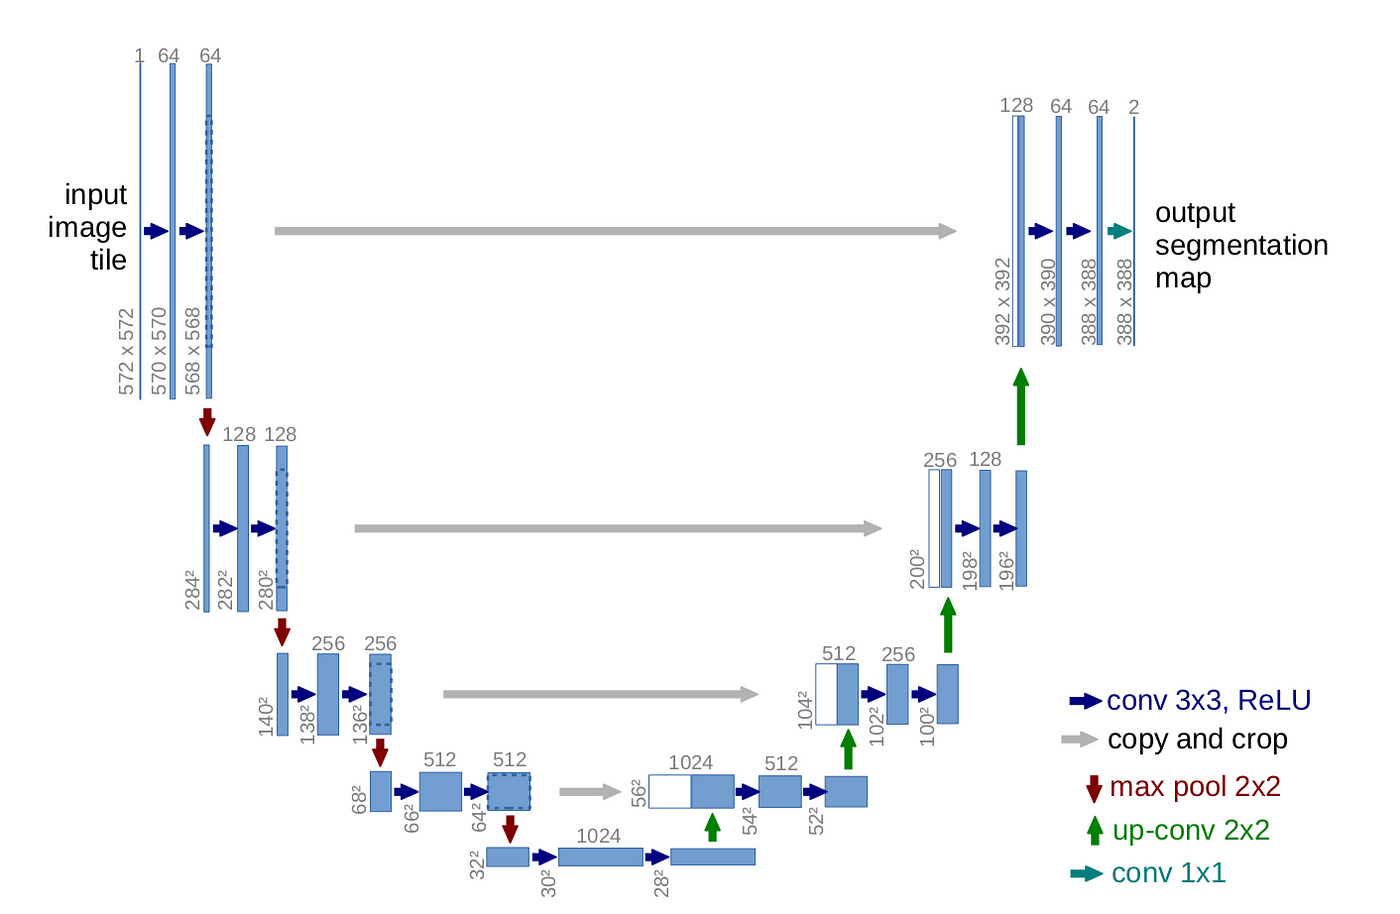

In [7]:
# Generally used to deepen the neural network for better performance
class DoubleConvolution(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    # Double convolution as a sequence of operations applied to data
    self.double_conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), # 2D convolution
                                     nn.BatchNorm2d(out_channels), # Batch normalization
                                     nn.ReLU(inplace = True), # The original input is modified instead of creating a new tensor
                                     nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1), # 2D convolution
                                     nn.BatchNorm2d(out_channels), # Batch normalization
                                     nn.ReLU(inplace = True)) # The original input is modified instead of creating a new tensor

  def forward(self, x):
    return self.double_conv(x)

# Used to reduce the dimensions of input feature maps and increase receptive field
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    # Performs max pooling and double convolution on reduced feature maps while increasing channels
    self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConvolution(in_channels, out_channels))

  def forward(self, x):
    return self.maxpool_conv(x)

# Used to increase the dimensions of the downsampled feature maps
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    # Used to increase the spatial dimensions of feature maps while decreasing the number of channels
    # The feature map grows twice each time because of kernel_size and stride but the channels get reduced
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    self.conv = DoubleConvolution(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)

    # x2 is cropped to match the dimensions of x1
    # shape[1] is the number of channels, shape[2] is for height, shape[3] is for width
    x2 = F.center_crop(x2, [x1.shape[2], x1.shape[3]])

    # Combines both feature maps to preserve both deep and shallow level details, concatenated horizontally
    x1 = torch.cat([x2, x1], dim = 1)

    return self.conv(x1)

class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.inc = (DoubleConvolution(in_channels, 64))
    self.down1 = (DownSample(64, 128))
    self.down2 = (DownSample(128, 256))
    self.down3 = (DownSample(256, 512))
    self.down4 = (DownSample(512, 1024))
    self.up1 = (UpSample(1024, 512))
    self.up2 = (UpSample(512, 256))
    self.up3 = (UpSample(256, 128))
    self.up4 = (UpSample(128, 64))
    # Used to decrease the number of channels so the kernel_size is 1
    self.outc = nn.Conv2d(64, out_channels, kernel_size = 1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

# Initialization of Device

Recommended to use GPU *(cuda:0)* for optimal performance.


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Used device type is', device)

Used device type is cuda:0


# Calculation of Statistics

**Intersection over Union (IoU)**

> $\text{IoU} = \frac{|A \cap B|}{|A \cup B|}$

* Measures the overlap between two sets divided by their union.
* Ranges from 0 to 1, where 0 indicates no overlap and 1 indicates perfect overlap.
* Direct measure of overlapping.
* Also known as Jaccard Index.


**Dice**

> $\text{Dice} = \frac{2|A \cap B|}{|A| + |B|}$

* Measures the overlap between two sets.
* Ranges from 0 to 1, where 0 indicates no overlap and 1 indicates perfect overlap.
* Dice emphasizes the overlap between two sets more strongly because there is a 2 in the numerator, making it more sensitive to overlaps.
* Practically the same as F1 score in the context of binary classification.

In [10]:
# Smooth is a small value that has litle impact, used to prevent division by zero

def iou(predictions, targets):
  smooth = 0.00001
  intersection = torch.sum(predictions * targets)
  union = torch.sum(predictions) + torch.sum(targets) - intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

def dice_coefficient(predictions, targets):
  smooth = 0.00001
  intersection = torch.sum(predictions * targets)
  union = torch.sum(predictions) + torch.sum(targets)
  dice = (2.0 * intersection + smooth) / (union + smooth)
  return dice

Used to calculate IoU and Dice using evaluation mode of the model.

In [11]:
def calculate_statistics(loader, model, threshold):
  dice_total = 0
  iou_total = 0
  all_predictions = []
  all_targets = []

  # Setting the model to evaluation mode
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      # x is for the image, y is for the mask
      x = x.to(device)
      y = y.to(device).unsqueeze(1)

      # Sigmoid is used as it is a binary classification task
      predictions = torch.sigmoid(model(x))
      # Threshold is applied
      predictions = (predictions > threshold).float()

      # Calculating Dice and IoU
      dice_total += dice_coefficient(predictions, y).item()
      iou_total += iou(predictions, y).item()

      all_predictions.extend(predictions.cpu().numpy().flatten())
      all_targets.extend(y.cpu().numpy().flatten())

  dice = dice_total / len(loader)
  mean_iou = iou_total / len(loader)

  print(f"Dice: {dice:.4f}")
  print(f"IoU: {mean_iou:.4f}")

  # Setting the model back to training mode
  model.train()

  return dice, mean_iou

# Saving Predictions as Images

In order to keep the document as concise as possible, images are saved to folder *predictions* instead of displaying them in the file.

Each threshold has a dedicated folder so the list of folders inside predictions should go as follows:

*   predictions/threshold_0.1
*   predictions/threshold_0.2
*   predictions/threshold_0.3
*   predictions/threshold_0.4
*   predictions/threshold_0.5
*   predictions/threshold_0.6
*   predictions/threshold_0.7
*   predictions/threshold_0.8
*   predictions/threshold_0.9

In each folder, two groups of files are present:

*   $x$.png, where $x$ is a number of the given (expected) mask set.
*   $predicted\_x$.png, where $x$ is a number of the predicted mask set.
*   So, for example, *1.png* is the set of expected masks for the first 16 images in the validation set, while *predicted_1.png* is the prediction of the model for these 16 images.

Each image file should contain 16 images as it is the size of the loader.

In [9]:
def save_predictions_as_imgs(loader, model, folder, threshold):
  # Setting the model to evaluation mode
  model.eval()

  # x is for the image, y is for the mask
  for index, (x, y) in enumerate(loader):

    # Passing the image to device
    x = x.to(device)

    with torch.no_grad():

      # Sigmoid is used as it is a binary classification task
      predictions = torch.sigmoid(model(x))

      # Threshold is applied
      predictions = (predictions > threshold).float()

    # Saving both predicted and original masks so they can be compared later
    torchvision.utils.save_image(predictions, f"{folder}/predicted_{index}.png")
    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{index}.png")

  # Setting the model back to training mode
  model.train()

# Training Functions

Used to calculate validation loss.

In [13]:
def calculate_validation_loss(loader, model, loss_function):
  model.eval()
  val_losses = []

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)

      predictions = model(x)
      loss = loss_function(predictions, y)
      val_losses.append(loss.item())

  avg_val_loss = sum(val_losses) / len(val_losses)

  return avg_val_loss

Used to train a single epoch.

In [12]:
def training_function(loader, model, optimizer, loss_function, scaler):
  model.train()
  train_losses = []

  for _, (data, targets) in enumerate(loader):
    data = data.to(device)
    targets = targets.float().unsqueeze(1).to(device)

    # Enables automatic casting to improve performance
    with torch.cuda.amp.autocast():
      predictions = model(data)
      # Calculates loss
      loss = loss_function(predictions, targets)

    # Clears gradients
    optimizer.zero_grad()
    # Scales the loss and computes the gradient of the loss
    scaler.scale(loss).backward()
    # Updates model parameters based on the calculated gradients
    scaler.step(optimizer)
    # Updates the scaler for the next iteration
    scaler.update()

    train_losses.append(loss.item())

  avg_train_loss = sum(train_losses) / len(train_losses)

  return avg_train_loss

The main training loop for all epochs.

In [14]:
def train_model(number_of_epochs, lr, model, threshold):
  loss_function = nn.BCEWithLogitsLoss() # Loss function specifically for binary segmentation
  optimizer = optim.Adam(model.parameters(), lr = lr)

  # Creating datasets and dataloaders
  train_dataset = CustomDataset(image_dir = train_image_dir, mask_dir = train_mask_dir, transform = train_transform)
  train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

  validation_dataset = CustomDataset(image_dir = validation_image_dir, mask_dir = validation_mask_dir, transform = validation_transform)
  validation_dataloader = DataLoader(validation_dataset, batch_size = 16, shuffle = False)

  scaler = torch.cuda.amp.GradScaler()

  train_losses = []
  validation_losses = []
  dice_scores = []
  mean_iou_scores = []
  epoch_times = []

  # Starting the timer to calculate total training time for a threshold
  total_start_time = time.time()

  for epoch in range(number_of_epochs):
    print(f"- EPOCH {epoch + 1} -")

    # Starting the timer to calculate training time for an epoch
    start_time = time.time()

    # Training the model
    train_loss = training_function(train_dataloader, model, optimizer, loss_function, scaler)
    train_losses.append(train_loss)

    # Calculating validation loss
    validation_loss = calculate_validation_loss(validation_dataloader, model, loss_function)
    validation_losses.append(validation_loss)

    # Calculating Dice and IoU
    dice, mean_iou = calculate_statistics(validation_dataloader, model, threshold)
    dice_scores.append(dice)
    mean_iou_scores.append(mean_iou)

    # Stopping the timer to calculate duration of training time for an epoch
    end_time = time.time()
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)

    # Converting seconds to more appropriate units of time
    hours, rem = divmod(epoch_duration, 3600)
    minutes, seconds = divmod(rem, 60)
    duration_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

    # Printing results for the epoch
    print("Training Loss:", train_loss)
    print("Validation Loss:", validation_loss)
    print("Epoch Training Duration:", duration_str)
    print()

    # Creating a folder to save predictions if it does not yet exist
    threshold_dir = f"../predictions/threshold_{threshold}/"
    if not os.path.exists(threshold_dir):
      os.makedirs(threshold_dir)

    # Saving these predictions in the folder
    save_predictions_as_imgs(validation_dataloader, model, threshold_dir, threshold)

    # If it is the last epoch
    if epoch == (number_of_epochs - 1):

      # Stopping the timer to calculate duration of total training time for a threshold
      total_end_time = time.time()
      total_duration = total_end_time - total_start_time

      # Converting seconds to more appropriate units of time
      total_hours, total_rem = divmod(total_duration, 3600)
      total_minutes, total_seconds = divmod(total_rem, 60)
      total_duration_str = f"{int(total_hours):02}:{int(total_minutes):02}:{int(total_seconds):02}"

      print(f"Total Training Duration for Threshold {threshold}:", total_duration_str)
      print()

      # Returning all of the relevant data to plot it later
      return train_losses, validation_losses, dice_scores, mean_iou_scores

# Training Cycle for each Threshold

Training parameters.

In [15]:
# Learning rate
lr = 0.001
number_of_epochs = 50

# Background threshold, goes from 0.1 to 0.9 with step of 0.1
thresholds = np.linspace(0.1, 0.9, num = 9)
thresholds = np.round(thresholds, 1)

Training loop.

In [16]:
# Dictionaries to store data for each threshold
all_dice_scores = {}
all_mean_iou_scores = {}
all_train_losses = {}
all_validation_losses = {}

# Training for each threshold
for index, threshold in enumerate(thresholds, start = 1):
  print(f'-- TRAINING WITH THRESHOLD OF {threshold:.1f} -- ')
  print()

  # Creating the model
  model = UNet(in_channels = 3, out_channels = 1).to(device)

  # Training the model
  train_losses, validation_losses, dice, mean_iou = train_model(number_of_epochs, lr, model, threshold)

  # Saving the model to a file
  torch.save(model.state_dict(), f'../models/UNet_Threshold_{threshold}.pth')

  # Adding the statistics for each threshold
  all_dice_scores[threshold] = dice
  all_mean_iou_scores[threshold] = mean_iou
  all_train_losses[threshold] = train_losses
  all_validation_losses[threshold] = validation_losses

-- TRAINING WITH THRESHOLD OF 0.1 -- 

- EPOCH 1 -
Dice: 0.5976
IoU: 0.4301
Training Loss: 0.35108038504918415
Validation Loss: 0.21142229220519462
Epoch Training Duration: 00:12:38

- EPOCH 2 -
Dice: 0.5091
IoU: 0.3473
Training Loss: 0.278939399321874
Validation Loss: 0.22112812971075377
Epoch Training Duration: 00:00:48

- EPOCH 3 -
Dice: 0.6135
IoU: 0.4473
Training Loss: 0.2687609406312307
Validation Loss: 0.19881297570342818
Epoch Training Duration: 00:00:48

- EPOCH 4 -
Dice: 0.4011
IoU: 0.2587
Training Loss: 0.2629616924126943
Validation Loss: 0.2689101764311393
Epoch Training Duration: 00:00:48

- EPOCH 5 -
Dice: 0.5984
IoU: 0.4311
Training Loss: 0.25941106577714285
Validation Loss: 0.19037044405316314
Epoch Training Duration: 00:00:49

- EPOCH 6 -
Dice: 0.5121
IoU: 0.3482
Training Loss: 0.2528874917825063
Validation Loss: 0.20157554668063918
Epoch Training Duration: 00:00:50

- EPOCH 7 -
Dice: 0.5633
IoU: 0.3968
Training Loss: 0.26042913595835365
Validation Loss: 0.201548761067

# Plotting Statistics

Two main categories of statistics concerning the model are:

* **Dice and Iou Scores** (plotted separately)
* **Training and Validation Losses** (plotted together)

Plotting Dice and IoU.

In [17]:
def plot_metric(thresholds, scores, number_of_epochs, label, locator = False):
  fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey = True)
  axes = axes.flatten()

  for ax, threshold in zip(axes, thresholds):
    epochs = range(1, number_of_epochs + 1)
    ax.plot(epochs, scores[threshold], label = label)

    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    ax.set_title(f'{label} | Threshold {threshold:.1f}')
    ax.legend()
    ax.grid(True)

    if locator:
      ax.yaxis.set_major_locator(MultipleLocator(0.05))

  plt.tight_layout()
  plt.show()

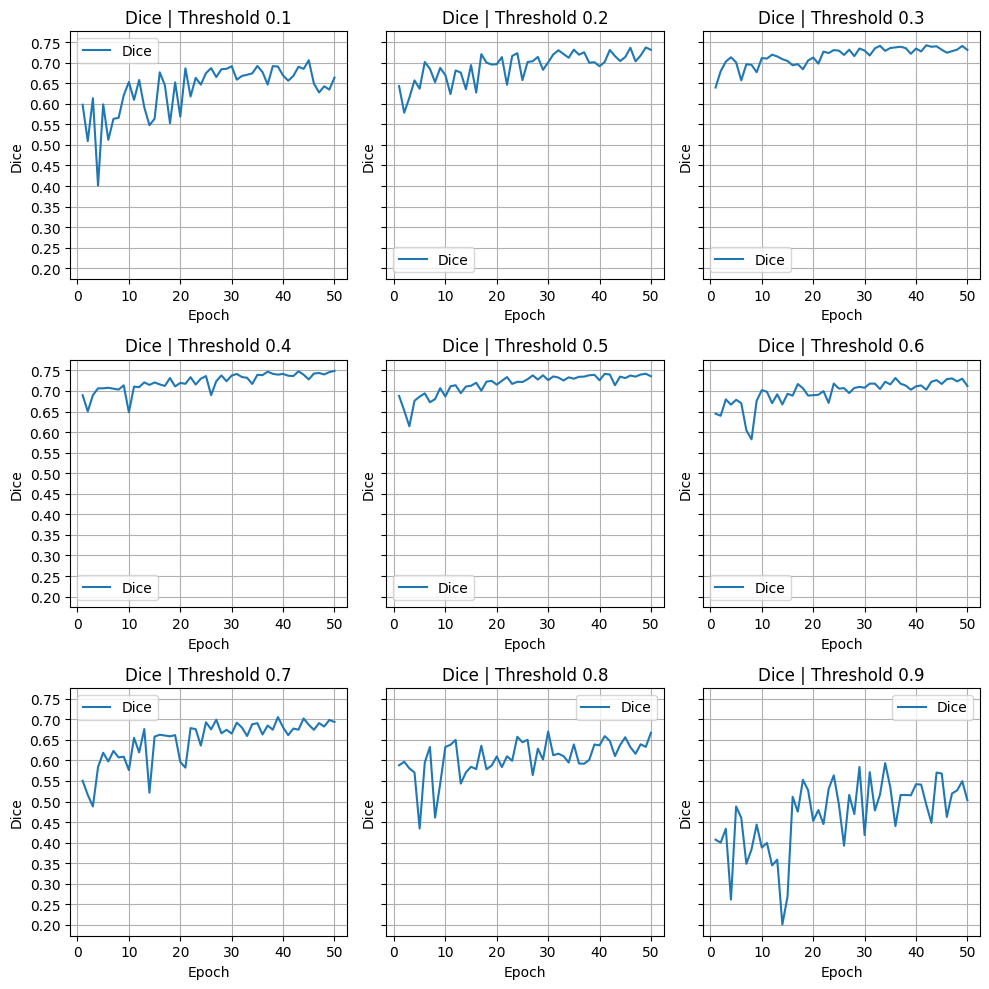

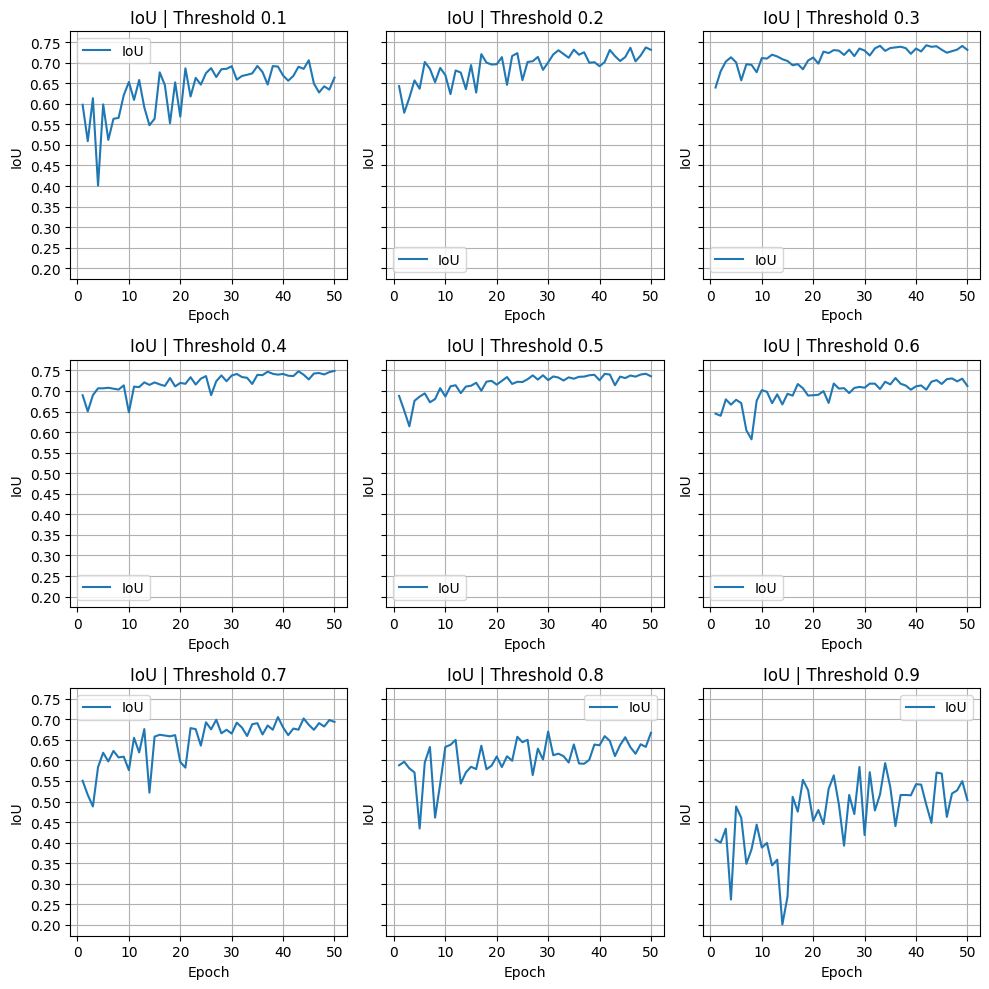

In [18]:
plot_metric(thresholds, all_dice_scores, number_of_epochs, 'Dice', True)
print()
plot_metric(thresholds, all_dice_scores, number_of_epochs, 'IoU', True)

Plotting Training and Validation losses.

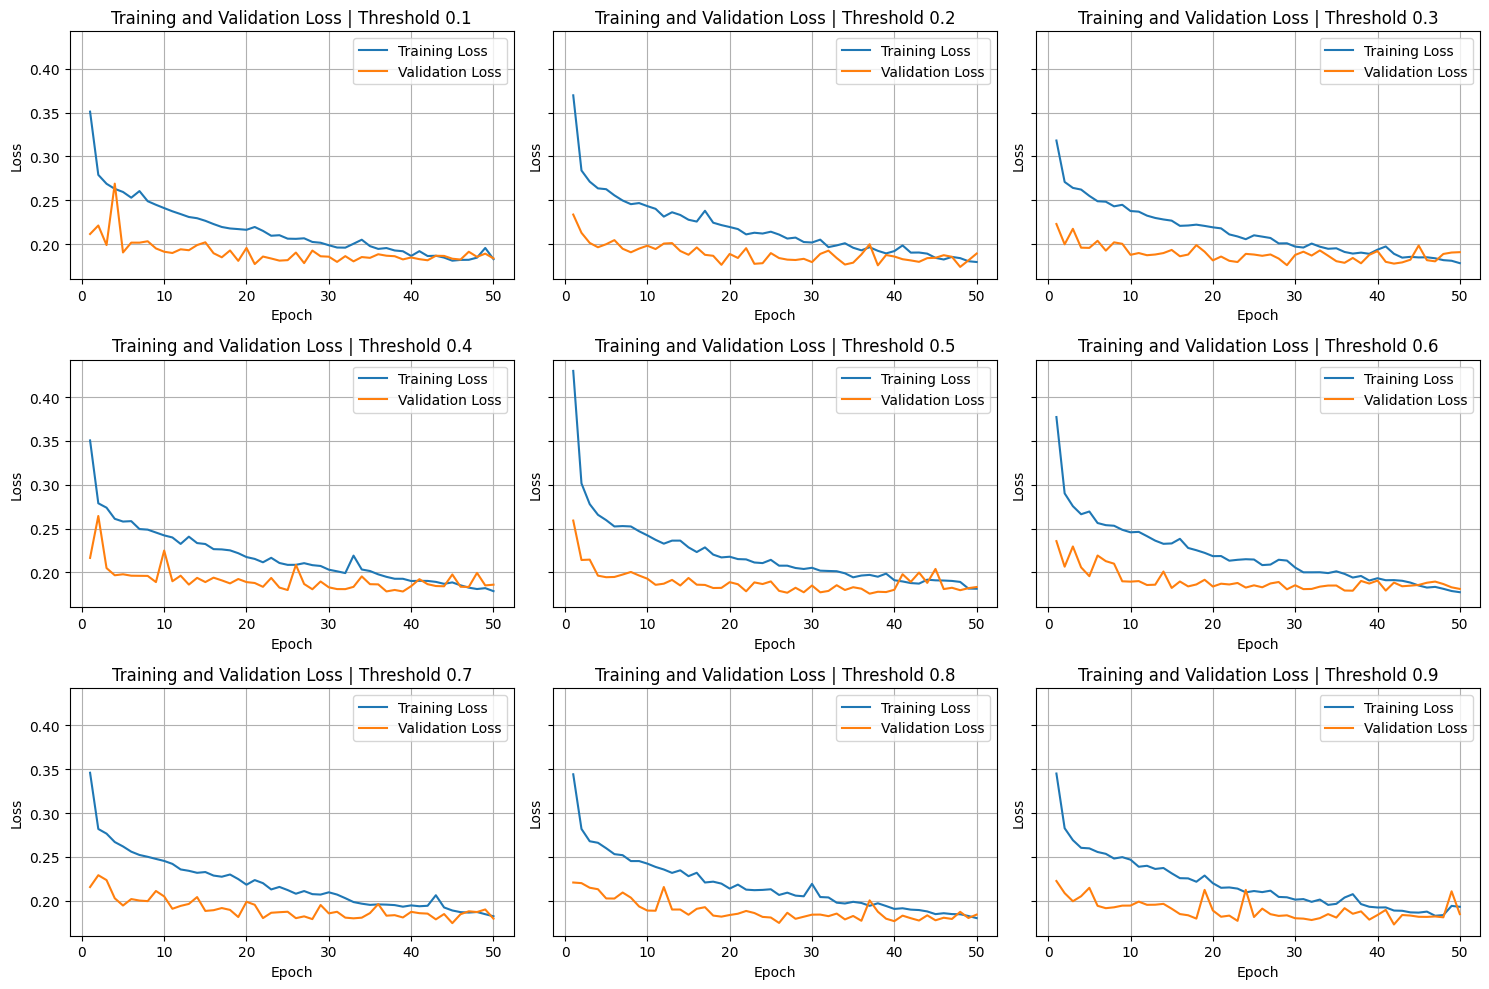

In [44]:
def plot_losses(thresholds, all_train_losses, all_val_losses, number_of_epochs):
  fig, axes = plt.subplots(3, 3, figsize = (15, 10), sharey = True)
  axes = axes.flatten()

  for ax, threshold in zip(axes, thresholds):
    epochs = range(1, number_of_epochs + 1)
    ax.plot(epochs, all_train_losses[threshold], label = 'Training Loss')
    ax.plot(epochs, all_validation_losses[threshold], label = 'Validation Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss | Threshold {threshold:.1f}')
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()

plot_losses(thresholds, all_train_losses, all_validation_losses, number_of_epochs)

# Downloading the Output – Predictions and Models

In [24]:
!zip -r /predictions.zip /predictions
!zip -r /models.zip /models

from google.colab import files

files.download("/predictions.zip")
files.download("/models.zip")

  adding: predictions/ (stored 0%)
  adding: predictions/threshold_0.9/ (stored 0%)
  adding: predictions/threshold_0.9/4.png (deflated 3%)
  adding: predictions/threshold_0.9/predicted_11.png (deflated 6%)
  adding: predictions/threshold_0.9/10.png (deflated 11%)
  adding: predictions/threshold_0.9/7.png (deflated 5%)
  adding: predictions/threshold_0.9/3.png (deflated 30%)
  adding: predictions/threshold_0.9/predicted_9.png (deflated 57%)
  adding: predictions/threshold_0.9/11.png (stored 0%)
  adding: predictions/threshold_0.9/predicted_3.png (deflated 34%)
  adding: predictions/threshold_0.9/predicted_7.png (deflated 9%)
  adding: predictions/threshold_0.9/predicted_4.png (deflated 5%)
  adding: predictions/threshold_0.9/predicted_8.png (deflated 9%)
  adding: predictions/threshold_0.9/predicted_1.png (deflated 5%)
  adding: predictions/threshold_0.9/1.png (deflated 3%)
  adding: predictions/threshold_0.9/0.png (deflated 12%)
  adding: predictions/threshold_0.9/9.png (deflated 56%)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## API ##

API should be used for testing purposes. A user may upload an image and get the mask of buildings back.

**File segmentator.html must be added to the root folder for the API interface to work!**

**Likewise, a model must be provided!**

API selects the best model based on Dice score and passes user input to it in order to get the mask and display it to the user.

Use the link as the API interface.

In [25]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://cyg8kyiosvg-496ff2e9c6d22116-5000-colab.googleusercontent.com/


Selecting and loading the best model available.

In [41]:
# Get the threshold with highest Dice score
best_threshold = max(all_dice_scores, key = all_dice_scores.get)
best_dice_score = all_dice_scores[best_threshold][-1]

print(f'Best threshold: {best_threshold} with Dice score: {best_dice_score}')

# Load the appropriate model based on the highest Dice score
best_model = UNet(in_channels = 3, out_channels = 1).to(device)
model_path = f'../models/UNet_Threshold_{best_threshold}.pth'

best_model.load_state_dict(torch.load(model_path))

Best threshold: 0.4 with Dice score: 0.7486291776100794


<All keys matched successfully>

Using Flask to handle user requests.

In [43]:
from flask import Flask, render_template, request
import torchvision.transforms as transforms
import io
import base64

app = Flask(__name__, template_folder='../')

@app.route('/', methods=['GET', 'POST'])
def index():
  original_image_base64 = None
  mask_base64 = None

  if request.method == 'POST':

    file = request.files['file']
    original_image = np.array(Image.open(file).convert("RGB"))

    transformed_image = validation_transform(image = original_image)['image']

    predicted_mask = best_model(torch.unsqueeze(transformed_image, 0).to(device))
    predicted_mask = torch.sigmoid(predicted_mask)
    predicted_mask = (predicted_mask > best_threshold).float().cpu().squeeze().numpy()

    mask_pil = transforms.ToPILImage()(predicted_mask)

    original_image_buffered = io.BytesIO()
    mask_buffered = io.BytesIO()

    Image.fromarray(original_image).save(original_image_buffered, format = "PNG")
    mask_pil.save(mask_buffered, format = "PNG")

    original_image_base64 = base64.b64encode(original_image_buffered.getvalue()).decode('utf-8')
    mask_base64 = base64.b64encode(mask_buffered.getvalue()).decode('utf-8')

  # Don't forget to upload segmentator.html to main folder!
  return render_template('segmentator.html', original_image = original_image_base64, mask = mask_base64)

if __name__ == "__main__":
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:47:32] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:47:33] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:47:36] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:47:38] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:47:50] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:47:52] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:49:52] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 20:49:54] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 21:12:11] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/May/2024 21:12:13] "GET /favicon.ico HTTP/1.1" 404